In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize

In [2]:
df = pd.read_csv('../monthly_collisions.csv')

In [3]:
df.head()

,Datetime,1ST AVE,1ST AVE S,4TH AVE S,AURORA AVE N,LAKE CITY WAY NE,RAINIER AVE S
0,2004-01-31,7,3,6,22,16,29
1,2004-02-29,14,6,9,23,5,34
2,2004-03-31,7,5,9,22,9,27
3,2004-04-30,11,3,11,22,12,27
4,2004-05-31,9,7,8,18,10,31


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199 entries, 0 to 198
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Datetime          199 non-null    object
 1   1ST AVE           199 non-null    int64 
 2   1ST AVE S         199 non-null    int64 
 3   4TH AVE S         199 non-null    int64 
 4   AURORA AVE N      199 non-null    int64 
 5   LAKE CITY WAY NE  199 non-null    int64 
 6   RAINIER AVE S     199 non-null    int64 
dtypes: int64(6), object(1)
memory usage: 11.0+ KB


In [5]:
df['Datetime'] = pd.to_datetime(df['Datetime'])

In [6]:
df = df.set_index('Datetime')

In [7]:
df = df[df.index < '2019-01-01']

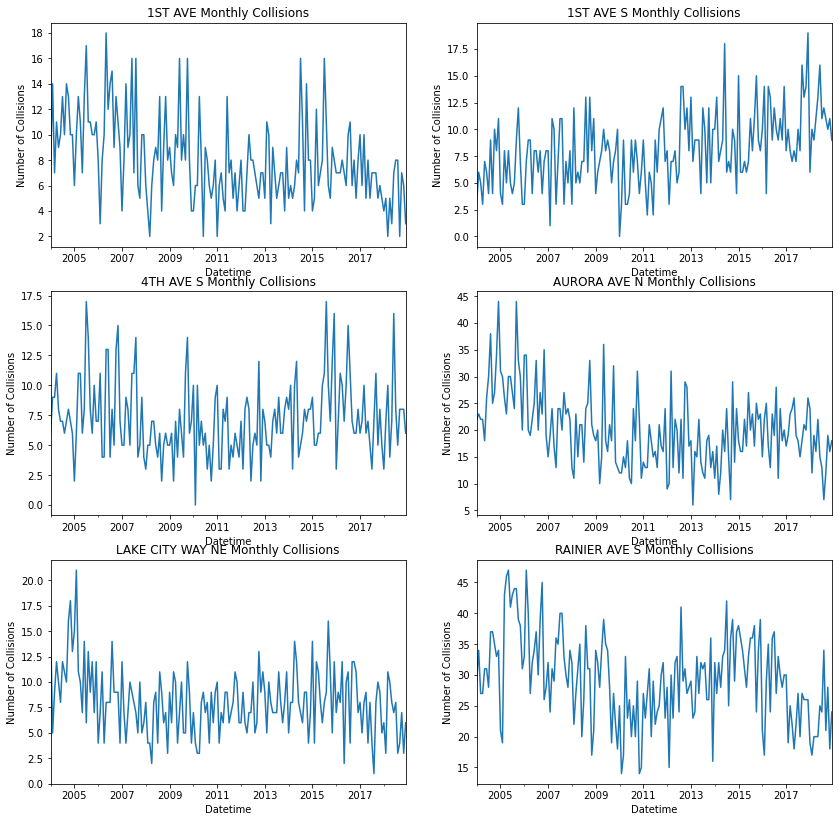

In [9]:
def plot_street(str_col, ax):
    ax.set_title(f'{str_col.name} Monthly Collisions')
    ax.set_ylabel('Number of Collisions')
    str_col.plot(ax=ax)
    
fig, ax = plt.subplots(3,2, figsize=(14,14))
#fig.tight_layout()

for idx, i in enumerate(ax.flatten()):
    plot_street(df[list(df.columns)[idx]], ax=i)

The goal is to find the unknown parameter $\lambda$, the rate of the monthly collisions. We'll start by finding this rate for each street. 

Let's use the poisson distribution:

$$
\frac{\lambda^k e^-k}{k!}
$$

Where $k$, is the number of collison events, a non-negative integer (0,1,2...) and $\lambda$ can be any positive number, by increasing it we add more probability to larger count of collision events, or conversely, by decreasing lambda, we add more probability to smaller values. One might call $\lambda$ the intensity of the Poisson distribution, and can be insightful for the level of danger a street may have.

which is good for counting events over time. The exponential would be useful for finding the time between these events, and would require a day by day look at the collisions. here we've aggregated by month to see the larger trend over the years, just as a starting point.

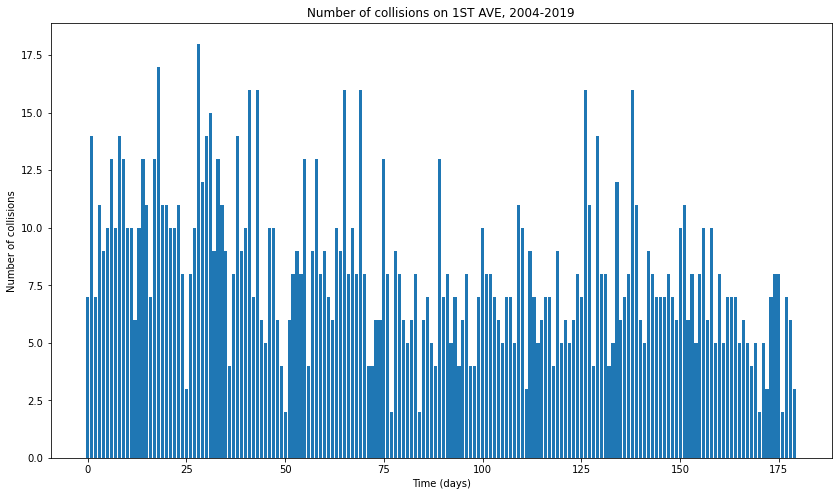

In [10]:
col = '1ST AVE'
df[col].sum()
plt.subplots(figsize=(14,8))
n_count = len(df['1ST AVE'])
plt.bar(np.arange(n_count), df['1ST AVE']);
plt.xlabel("Time (days)")
plt.ylabel("Number of collisions")
plt.title(f"Number of collisions on {df[col].name}, 2004-2019");

It seems that the rate changes over time, eventually a model with multiple values of $\lambda$ will be helpful.

Let's use an exponential distribution as our prior estimation of where to look for lambda's value, so to speak.

In [11]:
import pymc3 as pm
import theano.tensor as tt

# 1st Ave

In [330]:
street = '1ST AVE'
n_count = len(df[street])


count_data = df[street]

with pm.Model() as model:
    
    alpha = 1.0/count_data.mean()

    lambda_0 = pm.Exponential("lambda_0", alpha) 
    lambda_1 = pm.Exponential("lambda_1", alpha) 
    #lambda_2 = pm.Exponential("lambda_2", alpha) 

    tau_0 = pm.DiscreteUniform("tau_0", lower=0, upper=n_count-1)
    #tau_1 = pm.DiscreteUniform("tau_1", lower=tau_0, upper=n_count)


    idx = np.arange(n_count)
    lambda_ = pm.math.switch(tau_0 > idx, lambda_0, lambda_1)


    observation = pm.Poisson("obs", lambda_, observed=count_data)


    step = pm.Metropolis()
    trace = pm.sample(250_000, tune=25_000, step=step)

lambda_0_samples = trace['lambda_0']
lambda_1_samples = trace['lambda_1']
tau_samples = trace['tau_0']

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau_0]
>Metropolis: [lambda_1]
>Metropolis: [lambda_0]
Sampling 4 chains, 0 divergences: 100%|██████████| 1100000/1100000 [03:05<00:00, 5921.51draws/s]
The number of effective samples is smaller than 10% for some parameters.


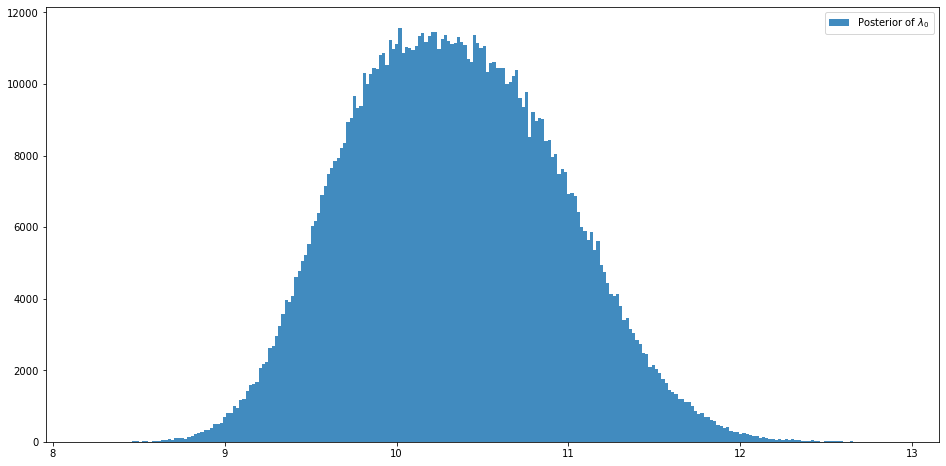

In [331]:
fig, ax = plt.subplots(figsize=(16,8))
#ax.set_autoscaley_on(False)

plt.hist(lambda_0_samples, histtype='stepfilled', bins=250, alpha=0.85, label='Posterior of $\lambda_0$')
plt.legend(loc='best')

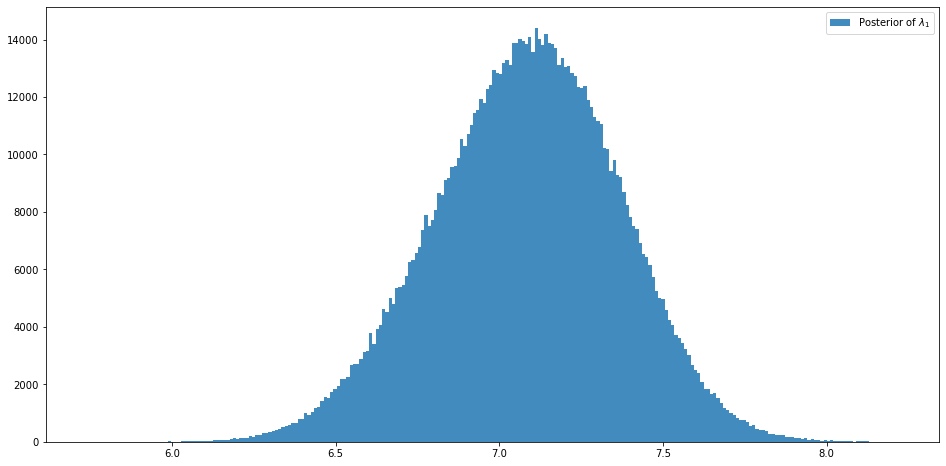

In [332]:
fig, ax = plt.subplots(figsize=(16,8))
#ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=250, alpha=0.85, label='Posterior of $\lambda_1$')
plt.legend(loc='best')

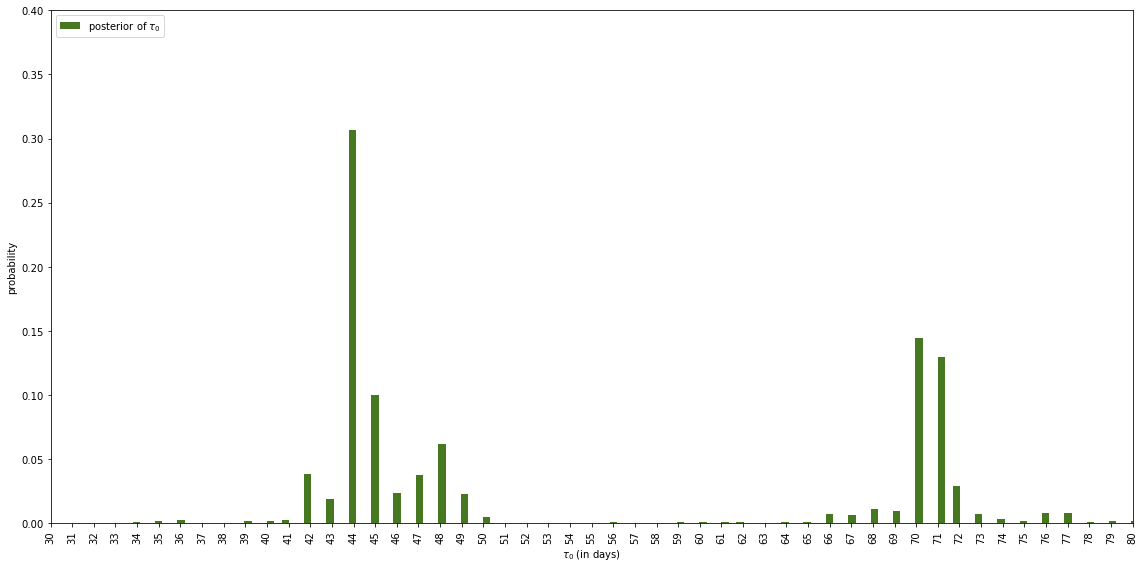

In [335]:
plt.subplots(figsize=(14,8))
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples, bins=n_count, alpha=1,
         label=r"posterior of $\tau_0$",
         color="#467821", weights=w, rwidth=2.)
plt.xticks(np.arange(n_count))

plt.legend(loc="upper left")
plt.ylim([0, .4])
plt.xlim([30, 80])
plt.xlabel(r"$\tau_0$ (in days)")
plt.xticks(rotation ='vertical')
plt.ylabel("probability");
plt.tight_layout()

In [325]:
figsize(14, 12)
# tau_samples, lambda_1_samples, lambda_2_samples contain
# N samples from the corresponding posterior distribution
N = tau_0_samples.shape[0]
expected_col_per_day = np.zeros(n_count)

for day in range(0, n_count):
    # ix is a bool index of all tau samples corresponding to
    # the switchpoint occurring prior to value of 'day'
    ix = day < tau_samples
    # Each posterior sample corresponds to a value for tau.
    # for each day, that value of tau indicates whether we're "before"
    # (in the lambda1 "regime") or
    #  "after" (in the lambda1 "regime") the switchpoint.
    # by taking the posterior sample of lambda0/1 accordingly, we can average
    # over all samples to get an expected value for lambda on that day.
    # As explained, the "message count" random variable is Poisson distributed,
    # and therefore lambda (the poisson parameter) is the expected value of
    # "message count".
    expected_col_per_day[day] = (lambda_0_samples[ix].sum()
                                   + lambda_1_samples[~ix].sum()) / N


plt.plot(range(n_count), expected_col_per_day, lw=4, color="#E24A33",
         label="expected number of collisions")
plt.xlim(0, n_count)
plt.xlabel("Day")
plt.ylabel("Expected # collisions")
plt.title(f'Expected number of collisions on {df[col].name}')
plt.ylim(0, 20)
plt.bar(np.arange(len(count_data)), count_data, color="#348ABD", alpha=0.65,
        label="observed collisions per day")

plt.legend(loc="upper left");



IndexError: boolean index did not match indexed array along dimension 0; dimension is 1000000 but corresponding boolean dimension is 2000000

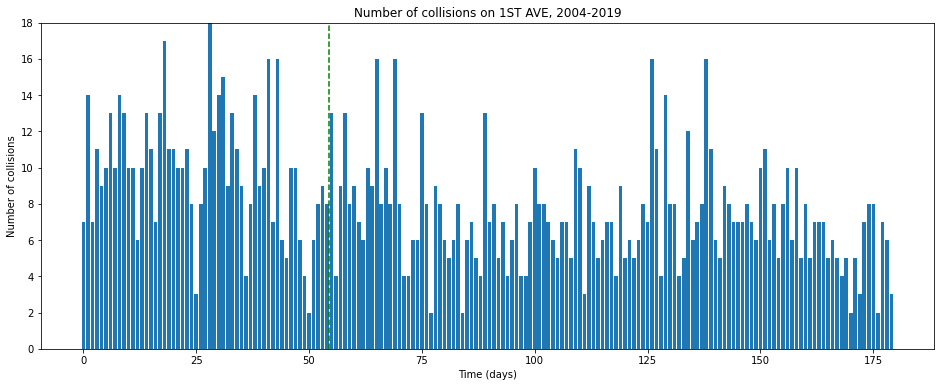

In [334]:
col = '1ST AVE'
df[col].sum()
plt.subplots(figsize=(16,6))
n_count = len(df['1ST AVE'])
plt.bar(np.arange(n_count), df['1ST AVE']);
plt.xlabel("Time (days)")
plt.ylabel("Number of collisions")
plt.ylim(0,df['1ST AVE'].max())
plt.title(f"Number of collisions on {df[col].name}, 2004-2019");
plt.vlines(tau_samples.mean(), 0,df['1ST AVE'].max(), color='green', linestyles='dashed', label='$tau_0$')

# Rainier Ave S

## Now what if there are multiple values for lambda?

In other words, the rate changes over time. That is what we could expect just looking at the line plot of the data, there are clear trends in periods of higher and lower collision counts.

Let's assume there are 3 different rates $\lambda$ and thus 2 'switchpoints' $\tau_1$ and $\tau_2$ (tau one and tau 2) where the rates change.

Finding the most likely point in time these 

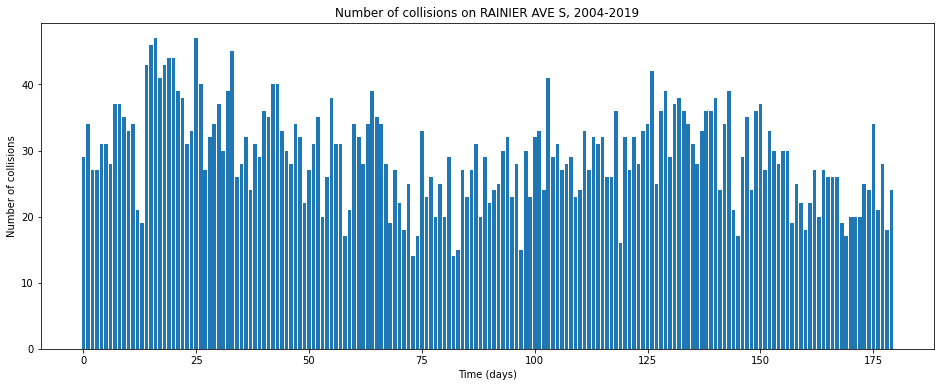

In [322]:
street = 'RAINIER AVE S'
df[street].sum()
plt.subplots(figsize=(16,6))
n_count = len(df[street])
plt.bar(np.arange(n_count), df[street]);
plt.xlabel("Time (days)")
plt.ylabel("Number of collisions")
plt.title(f"Number of collisions on {df[street].name}, 2004-2019");

In [262]:
n_count = len(df[street])

count_data = df[street]

with pm.Model() as model:
    
    alpha = 1.0/count_data.mean()

    lambda_0 = pm.Exponential("lambda_0", alpha) 
    lambda_1 = pm.Exponential("lambda_1", alpha) 
    lambda_2 = pm.Exponential("lambda_2", alpha) 

    tau_0 = pm.DiscreteUniform("tau_0", lower=0, upper=n_count-1)
    tau_1 = pm.DiscreteUniform("tau_1", lower=tau_0, upper=n_count)
    

In [263]:
with model:
    idx = np.arange(n_count)
    lambda_ = pm.math.switch(tau_1 >= idx, pm.math.switch(tau_0 >= idx, lambda_0, lambda_1), lambda_2)

In [264]:
with model:
    observation = pm.Poisson("obs", lambda_, observed=count_data)

In [265]:
with model:
    step = pm.Metropolis()
    trace = pm.sample(250_000, tune=25_000, step=step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau_1]
>Metropolis: [tau_0]
>Metropolis: [lambda_2]
>Metropolis: [lambda_1]
>Metropolis: [lambda_0]
Sampling 4 chains, 0 divergences: 100%|██████████| 1100000/1100000 [04:56<00:00, 3714.05draws/s]
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


In [266]:
lambda_0_samples = trace['lambda_0']
lambda_1_samples = trace['lambda_1']
lambda_2_samples = trace['lambda_2']
tau_0_samples = trace['tau_0']
tau_1_samples = trace['tau_1']

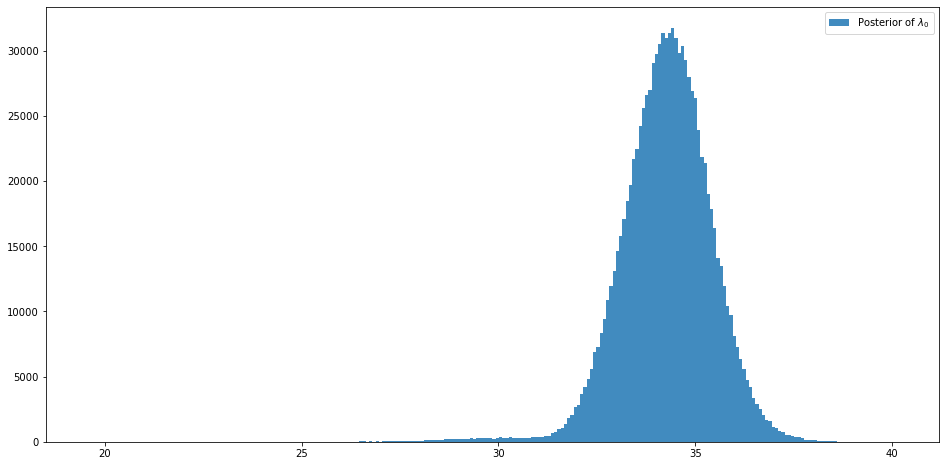

In [321]:
fig, ax = plt.subplots(figsize=(16,8))
#ax.set_autoscaley_on(False)

plt.hist(lambda_0_samples, histtype='stepfilled', bins=250, alpha=0.85, label='Posterior of $\lambda_0$')
plt.legend(loc='best')

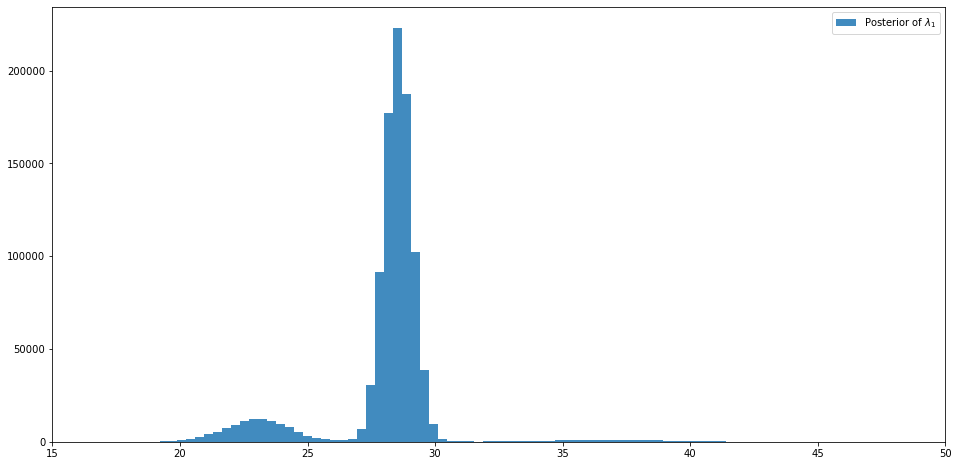

In [320]:
fig, ax = plt.subplots(figsize=(16,8))
#ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=250, alpha=0.85, label='Posterior of $\lambda_1$')
plt.xlim(15,50)
plt.legend(loc='best')

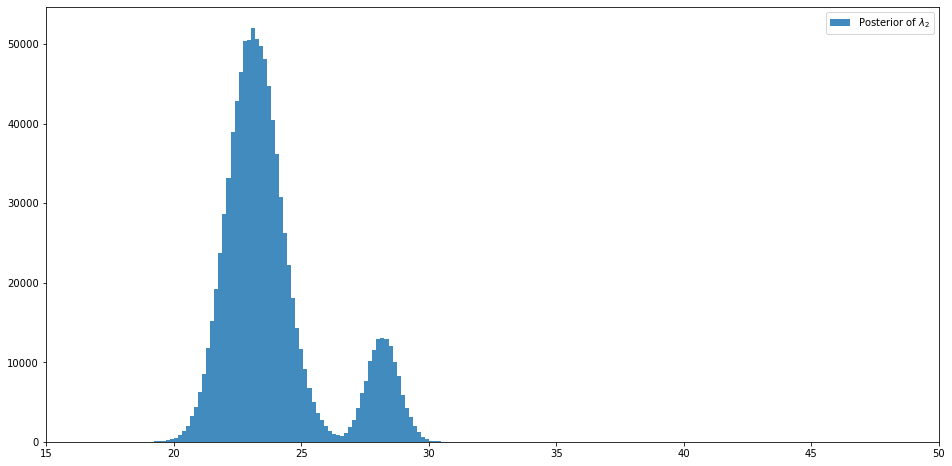

In [319]:
fig, ax = plt.subplots(figsize=(16,8))
#ax.set_autoscaley_on(False)

plt.hist(lambda_2_samples, histtype='stepfilled', bins=250, alpha=0.85, label='Posterior of $\lambda_2$')
plt.xlim(15,50)
plt.legend(loc='best')

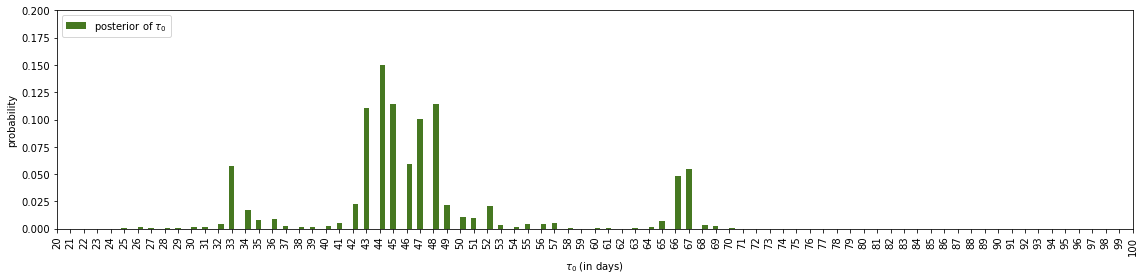

In [316]:
plt.subplots(figsize=(16,4))
w = 1.0 / tau_0_samples.shape[0] * np.ones_like(tau_0_samples)
plt.hist(tau_0_samples, bins=n_count, alpha=1,
         label=r"posterior of $\tau_0$",
         color="#467821", weights=w, rwidth=2.)
plt.xticks(np.arange(n_count))

plt.legend(loc="upper left")
plt.ylim([0, .2])
plt.xlim([20, 100])
plt.xlabel(r"$\tau_0$ (in days)")
plt.xticks(rotation ='vertical')
plt.ylabel("probability");
plt.tight_layout()

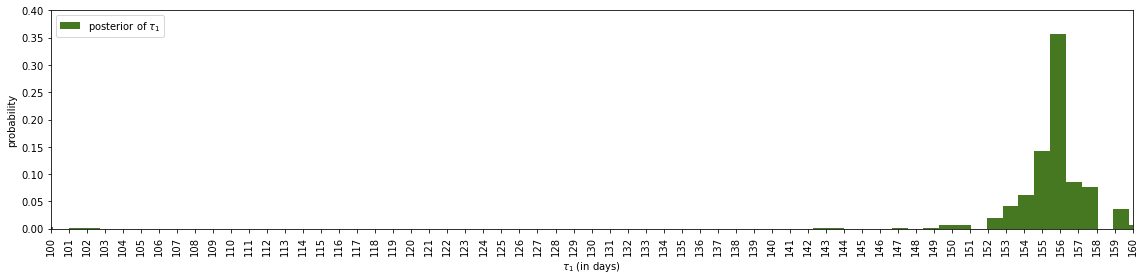

In [315]:
plt.subplots(figsize=(16,4))
w = 1.0 / tau_1_samples.shape[0] * np.ones_like(tau_1_samples)
plt.hist(tau_1_samples, bins=n_count, alpha=1,
         label=r"posterior of $\tau_1$",
         color="#467821", weights=w, rwidth=2.)
plt.xticks(np.arange(n_count))

plt.legend(loc="upper left")
plt.ylim([0, .4])
plt.xlim([100, len(count_data)-20])
plt.xlabel(r"$\tau_1$ (in days)")
plt.xticks(rotation ='vertical')
plt.ylabel("probability");
plt.tight_layout()

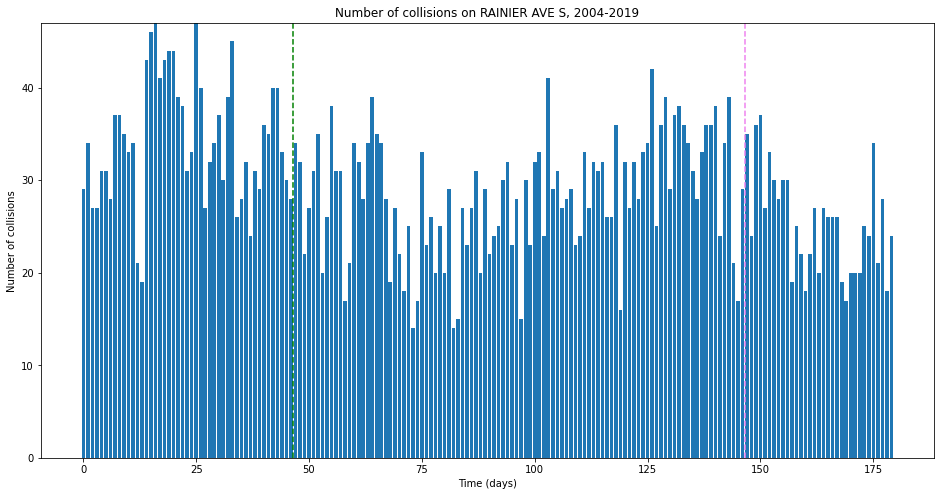

In [318]:
street = 'RAINIER AVE S'
df[street].sum()
plt.subplots(figsize=(16,8))
n_count = len(df[street])
plt.bar(np.arange(n_count), df[street]);
plt.xlabel("Time (days)")
plt.ylabel("Number of collisions")
plt.title(f"Number of collisions on {df[street].name}, 2004-2019");
plt.ylim(0,df[street].max())
plt.vlines(tau_0_samples.mean(), 0,df[street].max(), color='green', linestyles='dashed', label='$tau_0$')
plt.vlines(tau_1_samples.mean(), 0,df[street].max(), linestyles='dashed', label='$tau_1$',  color='violet')